# SELECCIÓN DE VARIABLES

La selección de variables es un proceso que implica elegir automáticamente las características más importantes de los datos que tienen un impacto significativo en la variable que estamos tratando de predecir.

Cuando tenemos características en nuestros datos que no son relevantes para la variable objetivo, pueden disminuir la precisión de ciertos modelos, especialmente aquellos que son sensibles a la presencia de variables irrelevantes, como la regresión lineal y logística.

Realizar la selección de características antes de construir un modelo proporciona varios beneficios:

1. Reduce el sobreajuste: Al eliminar características innecesarias, evitamos que el modelo se ajuste demasiado a detalles irrelevantes en los datos de entrenamiento, lo que mejora su capacidad para generalizar a nuevos datos.

2. Mejora la precisión en algunos modelos: Al centrarse en las características más importantes, se puede lograr una mejor precisión en la predicción, ya que el modelo se basa en información más relevante.

3. Reduce el tiempo de entrenamiento: Menos datos redundantes significan que los algoritmos pueden entrenarse más rápidamente, ya que tienen menos información para procesar. Esto es beneficioso, especialmente en conjuntos de datos grandes, ya que acelera el proceso de construcción del modelo.


Para seleccionar variables, además, ejecutaremos varios métodos de selección de variables que nos ayudarán a analizar las variables de nuestro dataset y, más tarde, poder realizar el feature engineering.

Estandarizamos las variables previamente a aplicar los métodos de selección de variables.

**Métodos de selección de variables a utilizar**:
1. **SelectFromModel**:
    - **Regularización Ridge**
    - **Regularización Lasso**
    - **Comparación Ridge y Lasso**
    
2. **Eliminación Recursiva de Características (RFE)**

### Librerías

En primer lugar, se importan las librerías necesarias y se cargan los datos guardados en los notebooks previos para emplearlos en los modelos.

In [1]:
import pandas as pd 
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import metrics
# conda install category_encoders
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from boruta import BorutaPy 
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Lectura dataset

In [3]:
pd_fraud = pd.read_csv("data/pd_fraud_02.csv")

Eliminación de la columna que se crea automáticamente al guardar el csv "Unnamed: 0": 

In [4]:
pd_fraud =pd_fraud.drop(columns=["Unnamed: 0"])
pd_fraud.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1.0,88.0,50,0.020925,-1.331345,AA,769.0,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1.0,144.0,50,0.005418,-0.816224,AB,366.0,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1.0,132.0,40,3.108549,-0.755728,AC,870.0,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1.0,22.0,50,0.019079,-1.205124,AB,810.0,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1.0,218.0,50,0.004441,-0.773276,AB,890.0,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


A continuación, para realizar la selección de variables y poder utilizar correctamente las regularizaciones Ridge y Lasso, en primer lugar distinguimos entre variables categóricas y continuas. Esto lo realizamos para después separar las variables en string y numéricas, puesto que en las numéricas ahora vamos a incluir las variables binarias. Esta distinción la hemos considerado oportuna para la posterior modelización de los algoritmos y puesto que las variables binarias son también numéricas.

In [5]:
lista_variables_categoricas = ["payment_type","employment_status","housing_status","email_is_free","phone_home_valid",
                                "phone_mobile_valid","has_other_cards","foreign_request","source","device_os","keep_alive_session"]

lista_variables_continuas = ["income", "name_email_similarity", "prev_address_months_count", "current_address_months_count", "customer_age", "days_since_request",
                            "intended_balcon_amount", "zip_count_4w", "velocity_6h", "velocity_24h", "velocity_4w", "bank_branch_count_8w", "date_of_birth_distinct_emails_4w",
                            "credit_risk_score", "bank_months_count", "proposed_credit_limit", "session_length_in_minutes", "device_distinct_emails_8w", "device_fraud_count",
                            "month"]
target = 'fraud_bool'

En lista_variables_numericas incluimos las variables binarias puesto que las consideramos numéricas

In [10]:
lista_variables_string = pd_fraud.select_dtypes(include=['object']).columns
lista_variables_numericas = pd_fraud.select_dtypes(include=['int64', 'float64']).columns

Eliminamos la variable 'device_fraud_count' de la lista_variables_numericas puesto que la vamos a eliminar a continuación y no la vamos a utilizar en futuros análisis.

In [15]:
lista_variables_numericas = lista_variables_numericas.drop(['device_fraud_count'])

## Previos comentarios a los análisis de selección de variables

Como vimos en el notebook02, la variable 'device_fraud_count' únicamente toma un valor por lo que decidimos eliminarla del dataset. 

Creamos un nuevo dataset en el que no quedan incluidas las variables a eliminar a continuación ('pd_fraud_reduced'):

In [16]:
pd_fraud_reduced = pd_fraud.drop(['device_fraud_count'], axis=1)

In [17]:
pd_fraud_reduced[lista_variables_numericas]

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month
0,1,0.9,0.166828,-1.0,88.0,50,0.020925,-1.331345,769.0,10650.765523,...,1,0,24,0,500.0,0,3.888115,0,1,7
1,1,0.9,0.296286,-1.0,144.0,50,0.005418,-0.816224,366.0,534.047319,...,0,0,15,0,1500.0,0,31.798819,0,1,7
2,1,0.9,0.044985,-1.0,132.0,40,3.108549,-0.755728,870.0,4048.534263,...,0,1,-1,0,200.0,0,4.728705,0,1,7
3,1,0.9,0.159511,-1.0,22.0,50,0.019079,-1.205124,810.0,3457.064063,...,0,1,31,1,200.0,0,2.047904,0,1,7
4,1,0.9,0.596414,-1.0,218.0,50,0.004441,-0.773276,890.0,5020.341679,...,1,0,31,0,1500.0,0,3.775225,1,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1.0,104.0,40,0.030592,-1.044454,804.0,7905.711839,...,1,1,25,0,200.0,0,8.511502,1,1,4
999996,0,0.8,0.322989,148.0,9.0,50,1.628119,-1.409803,3306.0,5391.470463,...,1,1,-1,0,200.0,0,8.967865,0,1,4
999997,0,0.8,0.879403,-1.0,30.0,20,0.018563,34.692760,1522.0,8063.102636,...,0,1,11,0,200.0,0,8.195531,0,1,4
999998,0,0.9,0.762112,-1.0,189.0,20,0.015352,94.661055,1418.0,8092.641762,...,1,0,28,0,500.0,0,4.336064,1,1,4


Además, para poder introducir las variables categóricas en los métodos de regularización de variables, hemos de pasar las variables categóricas a numéricas. Esto lo realizamos antes de estandarizar las variables.

Lo vamos a realizar de forma manual puesto que no son muchos los valores únicos que toma cada variable.

Por ello, primero vamos a ver los valores únicos de cada variable para después asignarle un número a cada valor.

In [88]:
pd_fraud_reduced['payment_type'].value_counts()

payment_type
AB    370554
AA    258249
AC    252071
AD    118837
AE       289
Name: count, dtype: int64

In [89]:
pd_fraud_reduced['payment_type'] = pd_fraud_reduced['payment_type'].replace(['AA'],0) 
pd_fraud_reduced['payment_type'] = pd_fraud_reduced['payment_type'].replace(['AB'],1) 
pd_fraud_reduced['payment_type'] = pd_fraud_reduced['payment_type'].replace(['AC'],2) 
pd_fraud_reduced['payment_type'] = pd_fraud_reduced['payment_type'].replace(['AD'],3) 
pd_fraud_reduced['payment_type'] = pd_fraud_reduced['payment_type'].replace(['AE'],4) 

In [90]:
pd_fraud_reduced['employment_status'].value_counts()

employment_status
CA    730252
CB    138288
CF     44034
CC     37758
CD     26522
CE     22693
CG       453
Name: count, dtype: int64

In [91]:
pd_fraud_reduced['employment_status'] = pd_fraud_reduced['employment_status'].replace(['CA'],0) 
pd_fraud_reduced['employment_status'] = pd_fraud_reduced['employment_status'].replace(['CB'],1) 
pd_fraud_reduced['employment_status'] = pd_fraud_reduced['employment_status'].replace(['CC'],2) 
pd_fraud_reduced['employment_status'] = pd_fraud_reduced['employment_status'].replace(['CD'],3) 
pd_fraud_reduced['employment_status'] = pd_fraud_reduced['employment_status'].replace(['CE'],4) 
pd_fraud_reduced['employment_status'] = pd_fraud_reduced['employment_status'].replace(['CF'],5) 
pd_fraud_reduced['employment_status'] = pd_fraud_reduced['employment_status'].replace(['CG'],6) 

In [92]:
pd_fraud_reduced['housing_status'].value_counts()

housing_status
BC    372143
BB    260965
BA    169675
BE    169135
BD     26161
BF      1669
BG       252
Name: count, dtype: int64

In [93]:
pd_fraud_reduced['housing_status'] = pd_fraud_reduced['housing_status'].replace(['BA'],0) 
pd_fraud_reduced['housing_status'] = pd_fraud_reduced['housing_status'].replace(['BB'],1) 
pd_fraud_reduced['housing_status'] = pd_fraud_reduced['housing_status'].replace(['BC'],2) 
pd_fraud_reduced['housing_status'] = pd_fraud_reduced['housing_status'].replace(['BD'],3) 
pd_fraud_reduced['housing_status'] = pd_fraud_reduced['housing_status'].replace(['BE'],4) 
pd_fraud_reduced['housing_status'] = pd_fraud_reduced['housing_status'].replace(['BF'],5) 
pd_fraud_reduced['housing_status'] = pd_fraud_reduced['housing_status'].replace(['BG'],6) 

In [94]:
pd_fraud_reduced['source'].value_counts()

source
INTERNET    992952
TELEAPP       7048
Name: count, dtype: int64

In [95]:
pd_fraud_reduced['source'] = pd_fraud_reduced['source'].replace(['INTERNET'],0) 
pd_fraud_reduced['source'] = pd_fraud_reduced['source'].replace(['TELEAPP'],1) 

In [96]:
pd_fraud_reduced['device_os'].value_counts()

device_os
other        342728
linux        332712
windows      263506
macintosh     53826
x11            7228
Name: count, dtype: int64

In [97]:
pd_fraud_reduced['device_os'] = pd_fraud_reduced['device_os'].replace(['windows'],0) 
pd_fraud_reduced['device_os'] = pd_fraud_reduced['device_os'].replace(['linux'],1) 
pd_fraud_reduced['device_os'] = pd_fraud_reduced['device_os'].replace(['macintosh'],2) 
pd_fraud_reduced['device_os'] = pd_fraud_reduced['device_os'].replace(['x11'],3)
pd_fraud_reduced['device_os'] = pd_fraud_reduced['device_os'].replace(['other'],4) 

**Conclusión**

A través de esta conversión de las variables categóricas a numéricas, cada una de las categorías de estas variables va a pasar a tener un valor numérico (por ejemplo, para la variable “housing_status” la categoría “BA” pasa a tomar un valor de 0 y la categoría “BB” un valor de 1).

Esta transformación es realizada para poder aplicar las regularizaciones de Lasso y Ridge al total de variables del conjunto de datos.

## ESTANDARIZACIÓN DE LAS VARIABLES

Para algunos modelos de predicción, es muy cómodo trabajar directamente sobre un dataset estandarizado, de manera que se tenga una media constante en todas las variables de 0 y una desviación típica igual a 1. Esto garantiza que todas las variables contribuyan de manera uniforme al proceso de regularización al tener la misma escala.

In [19]:
from sklearn.preprocessing import StandardScaler

escala = StandardScaler()
a = escala.fit_transform(pd_fraud_reduced.drop(["fraud_bool"],axis=1))
pd_fraud_std = pd.DataFrame(a, columns= pd_fraud_reduced.drop(["fraud_bool"],axis=1).columns)
aux = pd.DataFrame(pd_fraud_reduced['fraud_bool'])
aux.reset_index(inplace=True)
pd_fraud_std['fraud_bool']=aux['fraud_bool']

In [20]:
pd_fraud_std.describe().T

,count,mean,std,min,25%,50%,75%,max
income,1000000.0,-5.583587e-16,1.000000,-1.593620,-0.904778,0.128484,0.817326,1.161747
name_email_similarity,1000000.0,-5.687326e-16,1.000001,-1.707543,-0.928588,-0.005332,0.905745,1.751166
prev_address_months_count,1000000.0,-3.439027e-18,1.000000,-0.402272,-0.402272,-0.402272,-0.107128,8.315845
current_address_months_count,1000000.0,-6.357936e-17,1.000001,-0.990740,-0.764512,-0.391236,0.491051,3.861842
customer_age,1000000.0,2.415135e-16,1.000001,-1.969856,-1.138310,-0.306764,0.524782,4.682512
days_since_request,1000000.0,-1.280398e-17,1.000001,-0.190587,-0.189250,-0.187767,-0.185694,14.387517
intended_balcon_amount,1000000.0,1.653575e-16,1.000001,-1.195487,-0.486406,-0.469062,-0.181721,5.153918
payment_type,1000000.0,-1.177085e-16,1.000000,-1.274973,-1.274973,-0.240397,0.794179,2.863330
zip_count_4w,1000000.0,2.307132e-17,1.000001,-1.563291,-0.675064,-0.308037,0.369323,5.099901
velocity_6h,1000000.0,9.192576e-16,1.000001,-1.939237,-0.740661,-0.114817,0.669713,3.671943


Como muestra la anterior línea de código, las variables del conjunto de datos poseen media 0 y desviación típica 1, por lo que quedan estandarizadas.

Por ello, el dataframe 'pd_fraud_std' va a ser el que utilicemos en la selección de variables.

## Métodos de selección de las variables más importantes

## 1. SelectFromModel
[Información adicional](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)

SelectFromModel es una herramienta que puedes emplear junto a cualquier modelo que atribuya importancia a cada variable mediante un atributo específico, como coef_ o feature_importances. Elimina las características consideradas "poco importantes" si su importancia, medida por el umbral especificado, está por debajo de cierto valor. Además de establecer el umbral numéricamente, puedes utilizar heurísticas integradas, como "media", "mediana" o múltiplos flotantes de estas, como "0,1*media". También, puedes limitar el número de características seleccionadas con el parámetro max_features en combinación con el criterio de umbral.


[Información sobre elección de variables](https://scikit-learn.org/stable/modules/feature_selection.html)

### * Regresiones con regularización

En las regresiones con regularización, se introducen penalizaciones durante el ajuste mediante mínimos cuadrados ordinarios (OLS). El propósito es evitar el sobreajuste, reducir la variabilidad, contrarrestar la correlación entre predictores y minimizar la influencia de los predictores menos importantes en el modelo. Por lo general, al aplicar regularización, se logran modelos con una capacidad predictiva mejorada y una mejor generalización
Debido a que estos métodos de regularización afectan la magnitud de los coeficientes del modelo, es crucial que todos estén en la misma escala. Por esta razón, se requiere estandarizar o normalizar los predictores antes de entrenar el modelo.

### - Regularización Ridge

La regularización Ridge es una técnica que aplica una penalización a la suma de los coeficientes estimados, elevados al cuadrado. Esta penalización, conocida como "l2", tiene el efecto de reducir de manera proporcional el valor de todos los coeficientes del modelo, pero evita que lleguen a cero.

El grado de penalización está controlado por el hiperparámetro λ. Cuando λ=0, no hay penalización, y el resultado es equivalente al de un modelo line al mediante mínimos cuadrados ordinarios (OLS). A medida que λ aumenta, la penalización se intensifica, lo que conlleva a valores más pequeños para los predictores en el modelo.

[Información adicional](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html)

Total de características: 30
Características seleccionadas: 12
Variables seleccionadas: income, name_email_similarity, prev_address_months_count, customer_age, employment_status, credit_risk_score, email_is_free, housing_status, phone_home_valid, has_other_cards, device_os, keep_alive_session


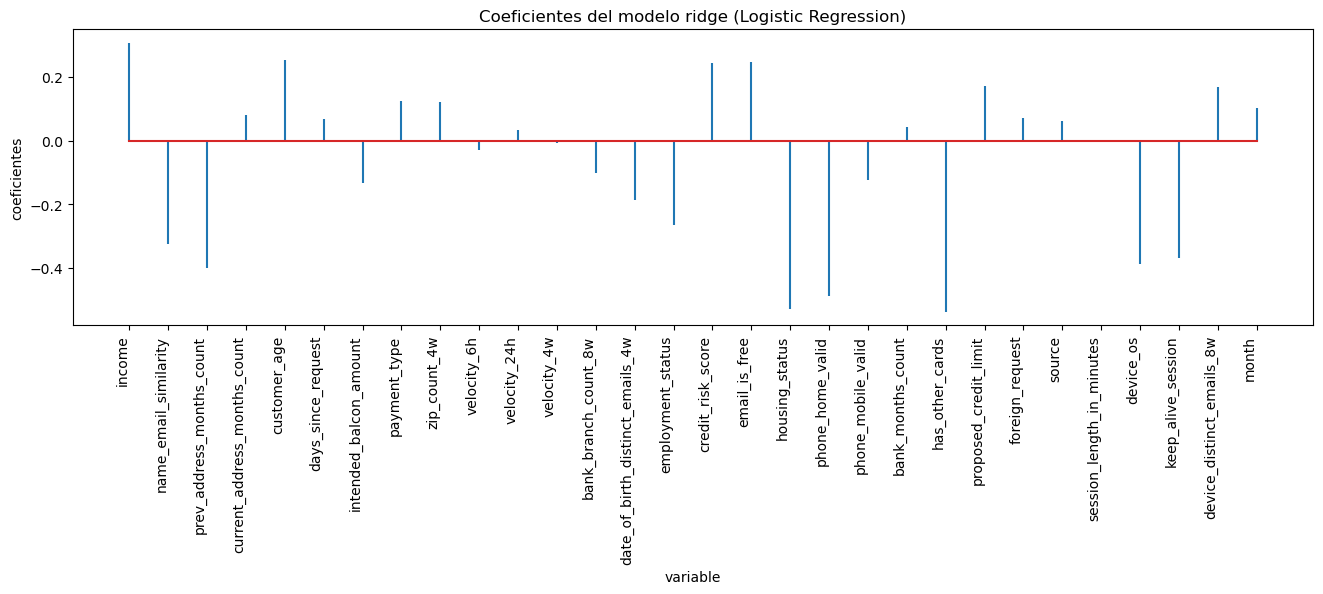

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

def logistic_ridge(X, y):
    sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold=0.2)
    # tras observar las importancias de las variables añadimos un threshold de 0.2
    
    sel_ridge.fit(X, y)
    
    # Coeficientes del modelo
    df_coeficientes = pd.DataFrame(
        {'predictor': X.columns,
         'coef': sel_ridge.estimator_.coef_.flatten()}
    )

    # Visualizar los coeficientes
    fig, ax = plt.subplots(figsize=(16, 3.84))
    ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
    plt.xticks(rotation=90, ha='right', size=10)
    ax.set_xlabel('variable')
    ax.set_ylabel('coeficientes')
    ax.set_title('Coeficientes del modelo ridge (Logistic Regression)')

    # Obtener las características seleccionadas
    selected_feat = X.columns[sel_ridge.get_support()]

    print('Total de características: {}'.format(X.shape[1]))
    print('Características seleccionadas: {}'.format(len(selected_feat)))
    print('Variables seleccionadas: ' + ', '.join(selected_feat))

    return selected_feat

# Llama a la función logistic_ridge con el DataFrame estandarizado
selected_features_logistic_ridge = logistic_ridge(pd_fraud_std.drop(['fraud_bool'], axis=1), pd_fraud_std['fraud_bool'])


In [70]:
sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold = 0.2)
# Instancia de un modelo de regresión logística con regularización l2. 
# El parámetro C controla la fuerza de la regularización, y penalty='l2' especifica el tipo de regularización.
# El modelo selecciona las características si sus coeficientes son mayores que 0.2.

sel_ridge.fit(pd_fraud_std.drop(['fraud_bool'], axis=1), pd_fraud_std['fraud_bool'])

SelectFromModel(estimator=LogisticRegression(C=1), threshold=0.2)

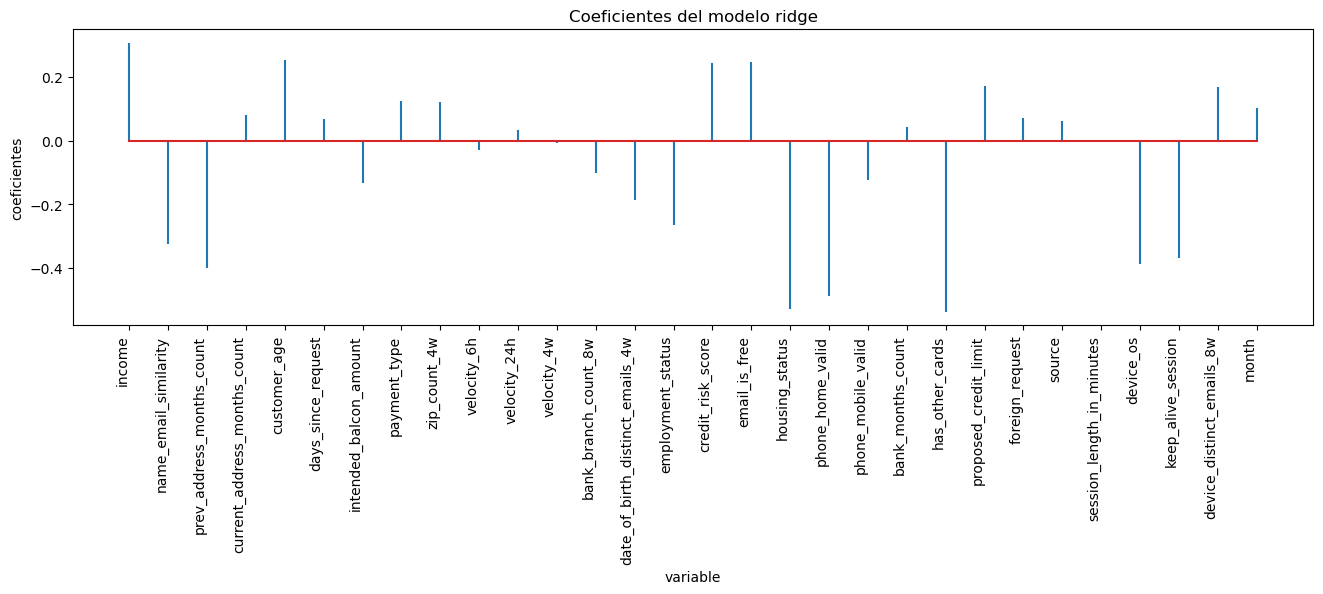

In [71]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': pd_fraud_std.drop(['fraud_bool'], axis=1).columns,
                         'coef': sel_ridge.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

Se observa la existencia tanto de correlaciones positivas como negativas.

In [72]:
sel_ridge.get_support()
selected_feat = pd_fraud_std.drop(['fraud_bool'], axis=1).columns[sel_ridge.get_support()]
selected_feat

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'customer_age', 'employment_status', 'credit_risk_score',
       'email_is_free', 'housing_status', 'phone_home_valid',
       'has_other_cards', 'device_os', 'keep_alive_session'],
      dtype='object')

In [73]:
print('total features: {}'.format((pd_fraud_std.drop(['fraud_bool'], axis=1).shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 30
selected features: 12


#### Conclusiones regularización Ridge


Observamos que la regularización de Ridge selecciona 12 de las 30 variables al establecer un threshold=0.2. A continuación, comprobaremos los resultados que se obtienen con Lasso. 

### - Regularización Lasso

La regresión Lasso, que utiliza la penalización L1, permite que algunos coeficientes sean exactamente cero. En el contexto de la función SelectFromModel, si no se proporcionan parámetros, esta técnica conserva todas las variables cuyos coeficientes no son cero. Sin embargo, si se desea limitar el número de variables seleccionadas, es necesario especificar valores para los parámetros correspondientes.

[Información adicional](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

In [56]:
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', 
                                          solver='liblinear'), threshold = 0.20) 
# Instancia de un modelo de regresión logística, con regularización L1. 
# La regularización L1 es conocida por crear dispersión en los coeficientes,
# y solver='liblinear' es un algoritmo específico para resolver problemas de optimización asociados con la regularización L1.
# 'Threshold=0.20', se seleccionan las características si sus coeficientes son mayores que 0.20.


sel_lasso.fit(pd_fraud_std.drop(['fraud_bool'], axis=1), pd_fraud_std['fraud_bool'])

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'),
                threshold=0.2)

In [62]:
sel_lasso.get_support()
selected_feat_lasso = pd_fraud_std.drop(['fraud_bool'], axis=1).columns[sel_lasso.get_support()]
selected_feat_lasso

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'customer_age', 'employment_status', 'credit_risk_score',
       'email_is_free', 'housing_status', 'phone_home_valid',
       'has_other_cards', 'device_os', 'keep_alive_session'],
      dtype='object')

In [63]:
print('total features: {}'.format((pd_fraud_std.drop(['fraud_bool'], axis=1).shape[1])))
print('selected features: {}'.format(len(selected_feat_lasso)))

total features: 30
selected features: 12


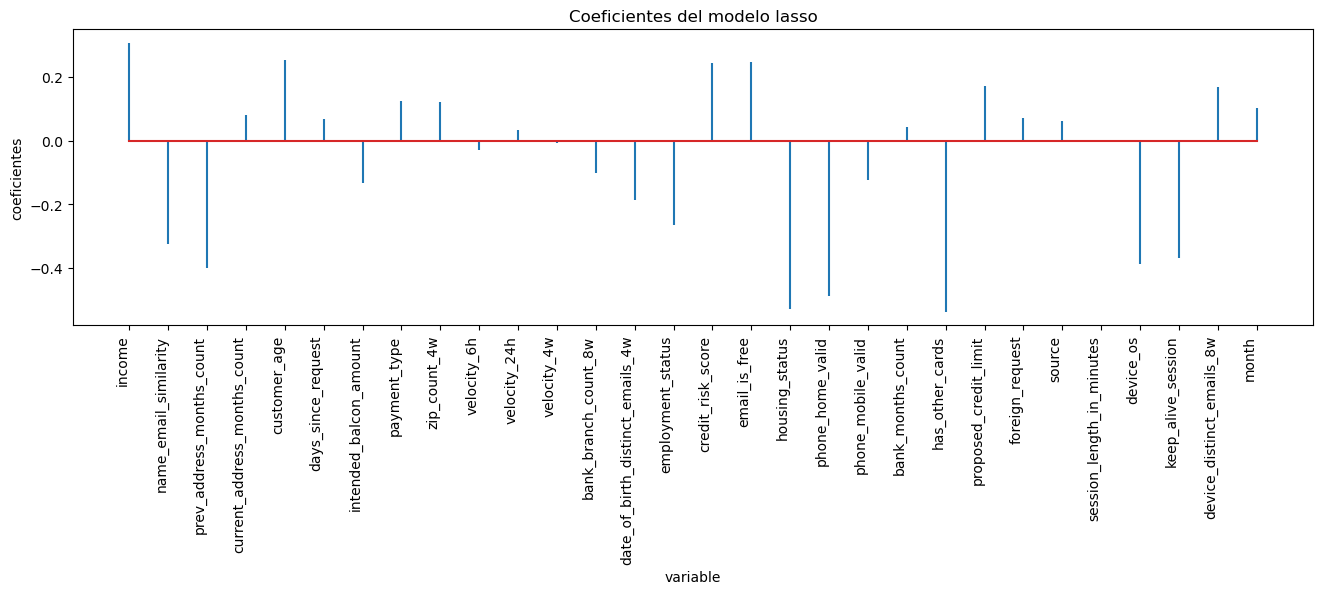

In [64]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': pd_fraud_std.drop(['fraud_bool'], axis=1).columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lasso');

In [74]:
print(selected_feat_lasso)
print(selected_features_logistic_ridge)

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'customer_age', 'employment_status', 'credit_risk_score',
       'email_is_free', 'housing_status', 'phone_home_valid',
       'has_other_cards', 'device_os', 'keep_alive_session'],
      dtype='object')
Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'customer_age', 'employment_status', 'credit_risk_score',
       'email_is_free', 'housing_status', 'phone_home_valid',
       'has_other_cards', 'device_os', 'keep_alive_session'],
      dtype='object')


#### Conclusiones regularización Lasso

La regularización Lasso al igual que Ridge selecciona únicamente 12 de 30 variables con un threshold=0.2; es más, selecciona no solo la misma cantidad de variables sino las mismas. Además, ninguna de las velocidades es escogida a través de este técnica, por lo que se podría confirmar de nuevo que una combinación de las tres velocidades por su media aritmética podría ser relevante (en vez, de permanecer las tres variables por separado).

Observamos que los mayores coeficientes otorgados por Lasso son a las variables 'housing_status', 'has_other_cards', y 'phone_home_valid'. En valor absoluto algo más de un 0.4.
Como comprobamos en anteriores notebooks, ya dijimos que la variables 'housing_status' era muy relevante, por lo que seguimos afirmando lo mencionado anteriormente.
En cuanto a las otras dos variables, seguiremos teniéndolas en cuenta en futuros análisis previos a la realización de los algoritmos.

Sin embargo, consideramos que por el significado que cada variable da al conjunto de datos (comprobado en el diccionario de datos del dataset), ninguna otra variable sería susceptible de ser eliminada por ahora.

### Comparación ridge y Lasso

![texto](https://keepcoding.io/wp-content/uploads/2022/12/image-40-1024x363.png)

Una distinción clave entre lasso y ridge radica en que lasso puede llevar algunos coeficientes a ser exactamente cero, realizando así una selección de variables para la predicción, mientras que ridge no excluye ninguno de manera completa. Este aspecto destaca la ventaja de lasso en situaciones donde no todos los predictores son cruciales para el modelo y se busca la exclusión de los menos influyentes.
En contraste, cuando se enfrenta a predictores altamente correlacionados, ridge reduce su influencia de manera simultánea y proporcional en todos ellos.

Para alcanzar un equilibrio óptimo entre estas dos propiedades, se puede recurrir a lo que se denomina penalización [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), que combina ambas estrategias de manera efectiva.

## 2. RFE

Dentro del contexto de la eliminación recursiva de características (RFE), se trabaja con un estimador externo que asigna pesos a las características, como los coeficientes de un modelo lineal. El propósito principal de RFE es seleccionar estas características de manera recursiva, considerando conjuntos cada vez más reducidos de variables. En la primera fase, el estimador se entrena utilizando el conjunto completo de variables, y se evalúa la importancia de cada una mediante algún atributo especí
específico. Luego, se eliminan las características menos relevantes del conjunto actual. Este proceso se repite de manera recursiva en el conjunto reducido hasta que se logra el número deseado de características a seleccionar.

[Información adicional](https://machinelearningmastery.com/rfe-feature-selection-in-python/)

In [75]:
# feature extraction
model = DecisionTreeClassifier()

# model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=12) 
# introduzco 12 como el valor deseado para selección de variables puesto que Ridge y Lasso han seleccionada esa cifra de variables

fit = rfe.fit(pd_fraud_std.drop(['fraud_bool'], axis=1), pd_fraud_std['fraud_bool'])


print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 12
Selected Features: [False  True False  True False  True  True False  True  True  True  True
  True  True False  True False False False False False False False False
 False  True False False False False]
Feature Ranking: [ 6  1 12  1  5  1  1 10  1  1  1  1  1  1  9  1 13  7 14 17  2 16  3 18
 19  1  8 15 11  4]


In [76]:
print(len(pd_fraud_std.drop(['fraud_bool'], axis=1).columns[fit.support_]), len(pd_fraud_std.drop(['fraud_bool'], axis=1).columns))

12 30


In [77]:
pd_fraud_std.drop(['fraud_bool'], axis=1).columns[fit.support_]

Index(['name_email_similarity', 'current_address_months_count',
       'days_since_request', 'intended_balcon_amount', 'zip_count_4w',
       'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'session_length_in_minutes'],
      dtype='object')

Tras ver las variables seleccionadas y ver que no se han incluido variables como 'housing_status' o 'income' que ya hemos visto que tienen las correlaciones más altas con la variable objetivo y que son las que más valor obtienen con Lasso o Ridge decidimos no considerar la selección por RFE en nuestro análisis.

### Eliminación de variables

In [30]:
pd_fraud.nunique()

fraud_bool                               2
income                                   9
name_email_similarity               998861
prev_address_months_count              374
current_address_months_count           423
customer_age                             9
days_since_request                  989330
intended_balcon_amount              994971
payment_type                             5
zip_count_4w                          6306
velocity_6h                         998687
velocity_24h                        998940
velocity_4w                         998318
bank_branch_count_8w                  2326
date_of_birth_distinct_emails_4w        40
employment_status                        7
credit_risk_score                      551
email_is_free                            2
housing_status                           7
phone_home_valid                         2
phone_mobile_valid                       2
bank_months_count                       33
has_other_cards                          2
proposed_cr

A continuación, vamos a considerar la eliminación de otras variables según los resultados obtenidos hasta ahora en todos los notebooks.

Vamos a analizar en mayor profundidad las variables prev_address_months_count y intended_balcon_amount puesto que como explicamos en el notebook 2 presentan muchos missings, y así poder decidir qué hacer con ellas.

<BarContainer object of 100 artists>

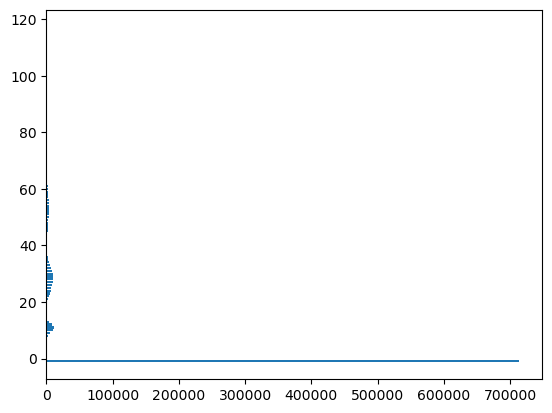

In [17]:
top_100_values = pd_fraud['prev_address_months_count'].value_counts().head(100)
plt.barh(top_100_values.index, top_100_values)

<BarContainer object of 500 artists>

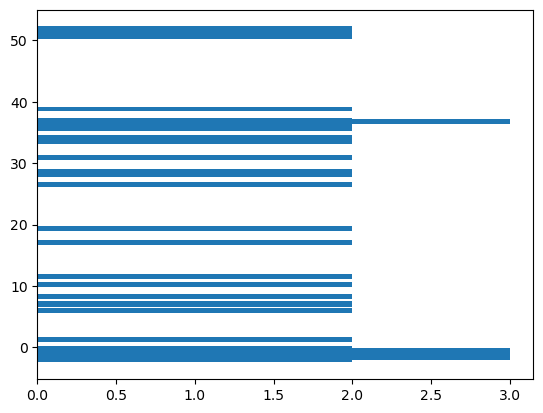

In [67]:
top_100_values = pd_fraud['intended_balcon_amount'].value_counts().head(500)
plt.barh(top_100_values.index, top_100_values)

In [69]:
pd_fraud['prev_address_months_count'].nunique()

374

In [70]:
pd_fraud['intended_balcon_amount'].nunique()

994971

Ahora comprobamos cuántos de estos valores son negativos puesto que todos sus negativos son missings entonces es normal que la cantidad de valores únicos sea más alto.

In [72]:
pd_fraud[pd_fraud['intended_balcon_amount'] < 0]['intended_balcon_amount'].nunique()

737834

In [73]:
pd_fraud[pd_fraud['intended_balcon_amount'] > 0]['intended_balcon_amount'].nunique()

257137

In [66]:
variables = ['prev_address_months_count', 'current_address_months_count','intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']
missing_count = []
missing_percentage = []

# Calcular la cantidad y porcentaje de valores nulos para cada variable
for variable in variables:
    if variable == 'intended_balcon_amount':
        missing_count.append(pd_fraud[pd_fraud[variable] < 0].shape[0])
    else:
        missing_count.append(pd_fraud[pd_fraud[variable] == -1].shape[0])

    missing_percentage.append((missing_count[-1] /len(pd_fraud) * 100))

# Crear un DataFrame con la información
missing_data_df = pd.DataFrame({
    'Variable': variables,
    'Missing': missing_count,
    'Porcentaje Missing': missing_percentage
})

# Imprimir el DataFrame
missing_data_df

,Variable,Missing,Porcentaje Missing
0,prev_address_months_count,712920,71.2920
1,current_address_months_count,4254,0.4254
2,intended_balcon_amount,742523,74.2523
3,bank_months_count,253635,25.3635
4,session_length_in_minutes,2015,0.2015
5,device_distinct_emails_8w,359,0.0359


Como podemos comprobar, los missings de estas dos variables son muy altos superando en ambos casos el 70%. Además, hemos acotado sus valores en los 100 primeros para ver cómo se distribuyen. Comprobamos que los valores de la variable **'prev_address_months_count'**, aunque no sean muy variados, en los boxplot del notebook 2 se observan distribuciones diferentes entre fraude y no fraude. Eso, sumado a que tanto Lasso como Ridge la incluyen entre las 12 variables seleccionadas nos hace decantarnos por dejarla en el dataset.

Por otro lado, con respecto a la variable **'intended_balcon_amount'** hemos comprobado que, aunque presenta también un porcentaje mayor al 70% de valores faltantes, hay 257137 valores únicos positivos (puesto que todos los negativos son missings). Por lo tanto, consideramos que esta variable debe permanecer en el conjunto de datos por su variabilidad. 

Además de los cambios realizados y guardados en el dataset 'pd_fraud_reduced' que es un dataset sobre el que hemos eliminado variables que no aportan nada en el modelo y sobre el que haremos combinaciones de variables con altas correlaciones en el próximo notebook, decidimos crear uno nuevo únicamente con las 12 variables seleccionadas por las regularizaciones Ridge y Lasso al que llamaremos 'pd_fraud_selection'.

In [99]:
pd_fraud_selection = pd_fraud_reduced[selected_features_logistic_ridge]
pd_fraud_selection['fraud_bool'] = pd_fraud_reduced['fraud_bool']
pd_fraud_selection.head()

,income,name_email_similarity,prev_address_months_count,customer_age,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,has_other_cards,device_os,keep_alive_session,fraud_bool
0,0.9,0.166828,-1.0,50,0,185.0,0,0,1,0,0,0,1
1,0.9,0.296286,-1.0,50,0,259.0,1,0,0,0,0,0,1
2,0.9,0.044985,-1.0,40,1,177.0,1,0,0,0,4,0,1
3,0.9,0.159511,-1.0,50,0,110.0,1,0,0,1,1,0,1
4,0.9,0.596414,-1.0,50,0,295.0,1,0,1,0,2,1,1


## Conclusiones

- Se ha **eliminado la variable 'device_fraud_count'** al únicamente tomar el valor 0 y se ha creado el dataframe  'pd_fraud_reduced'.
- Para poder introducir las variables categóricas en los métodos de regularización de variables, hemos **pasado las variables categóricas a numéricas**: a través de esta conversión cada una de las categorías de estas variables va a pasar a tener un valor numérico.
- Con anterioridad a la selección de variables se ha llevado a cabo la **estandarización de las variables**  y la creación del dataframe 'pd_fraud_std'.
- **Regularización Ridge**: La regularización de Ridge selecciona 12 de las 30 variables al establecer un threshold=0.2 en 'pd_fraud_std'.
- **Regularización Lasso**: La regularización de Lasso seleciona las mismas 12 variables que Ridge con un threshold=0.2. Además, ninguna de las velocidades es escogida a través de este técnica, por lo que se podría confirmar de nuevo que una combinación de las tres velocidades por su media aritmética podría ser relevante. Observamos que los mayores coeficientes otorgados por Lasso son a las variables 'housing_status', 'has_other_cards', y 'phone_home_valid' por lo que seguiremos teniéndolas en cuenta en futuros análisis previos a la realización de los algoritmos.
- Sin embargo, consideramos que por el significado que cada variable da al conjunto de datos (comprobado en el diccionario de datos del dataset), **ninguna otra variable sería susceptible de ser eliminada por ahora**.
- **RFE**: al observar las variables seleccionadas y ver que no se han incluido variables como 'housing_status' o 'income' las cuales poseen las correlaciones más altas con la variable objetivo y que son las que más valor obtienen con Lasso o Ridge **decidimos no considerar la selección por RFE en nuestro análisis**.
- Al analizar en mayor profundidad las **variables que comentamos en el notebook 2 que presentaban más de un 70% de valores missings** ('prev_address_months_count' y 'intended_balcon_amount') se concluye que:
    - Comprobamos que los valores de la variable 'prev_address_months_count' aunque no sean muy variados, en los boxplot del notebook 2 se observan distribuciones diferentes entre fraude y no fraude. Eso, sumado a que tanto Lasso como Ridge la incluyen entre las 12 variables seleccionadas nos hace decantarnos por dejarla en el dataset.
    
    - Por otro lado, con respecto a la variable 'intended_balcon_amount' hemos comprobado que, aunque presenta también un porcentaje mayor al 70% de valores faltantes, sus valores únicos positivos (puesto que todos los negativos son missings) suman 257137. Por lo tanto, consideramos que esta variable debe permanecer en el conjunto de datos.

- El datataset **'pd_fraud_reduced'** es sobre el que hemos eliminado variables que no aportan y sobre el que haremos combinaciones de variables con altas correlaciones en el próximo notebook. Además, hemos decidido crear uno nuevo únicamente con las 12 variables seleccionadas por las regularizaciones Ridge y Lasso al que llamaremos **'pd_fraud_selection'**.

A continuación guardamos los datasets creados en formato csv.

In [100]:
pd_fraud_reduced.to_csv("data/pd_fraud_reduced.csv")

In [101]:
pd_fraud_selection.to_csv("data/pd_fraud_selection.csv")